# Download Dataset

In [ ]:
# Uncomment these to download the dataset
# mkdir("../dataset")
# cd("../dataset") do
#     run(`wget http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip`) 
#     run(`unzip mini_speech_commands.zip`)
# end
using Markdown

Markdown.parse_file("../dataset/mini_speech_commands/README.md")

In [24]:
# The Evaliable Commands
commands = [c for c=readdir("../dataset/mini_speech_commands") if c!="README.md"]

8-element Vector{String}:
 "down"
 "go"
 "left"
 "no"
 "right"
 "stop"
 "up"
 "yes"

In [25]:
# Gather file pathes
using Glob
using Random
filenames = glob("../dataset/mini_speech_commands/*/*") |> shuffle
num_examples = length(readdir("../dataset/mini_speech_commands/$(commands[1])"))
println("Number of total examples: ",length(filenames))
println("Number of examples per label: ", num_examples)
println("Example File Tensor: ", filenames[1])

Number of total examples: 8000
Number of examples per label: 1000
Example File Tensor: ..\dataset\mini_speech_commands\stop\62581901_nohash_1.wav

In [26]:
# Separate the data set in training data, validation data and test data

train_files = filenames[1:6400]
val_files = filenames[6401:7200]
test_files = filenames[7201:8000]

println("Training set size: ", length(train_files))
println("Validation set size: ", length(val_files))
println("Test set size: ", length(test_files))

Training set size: 6400
Validation set size: 800
Test set size: 800


In [27]:
# Check loading WAVs
using WAV
test_audio, fs = wavread("../dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav")
@show fs
@show size(test_audio)

fs = 16000.0f0
size(test_audio) = (13654, 1)


(13654, 1)

In [28]:
# Function to load WAVs
function decode_audio(audio_binary)
    audio, fs = wavread(audio_binary)
    audio[:,1]
end
decode_audio("../dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav")

13654-element Vector{Float64}:
 0.0017700735496078372
 0.002990813928647725
 0.002838221381267739
 0.003021332438123722
 0.0024719992675557726
 0.003143406476027711
 0.0027466658528397473
 0.0019531846064638203
 0.0020142216254158147
 0.0019226660969878231
 ⋮
 0.020477919858394117
 0.020020142216254158
 0.020264290292062136
 0.021698660237434005
 0.023102511673329874
 0.025818659016693626
 0.025269325846125675
 0.029725028229621267
 0.017761772515030368

In [29]:
# Function to get command label
function get_label(file_path)
    split(file_path,"\\")[end-1] # For Windows System otherwise replace with /
end
get_label(filenames[1])

"stop"

In [30]:
# Function to get WAV with Label
get_waveform_and_label(file_path) = begin
   # @show file_path
    decode_audio(file_path), get_label(file_path)
end

get_waveform_and_label(filenames[1])


([-0.0152287362285226, -0.01663258766441847, -0.014191106906338695, -0.013855403302102725, -0.015015106662190619, -0.015564439832758568, -0.013794366283150731, -0.014191106906338695, -0.015076143681142613, -0.013000885036774804  …  -0.03540147099215674, -0.028839991454817346, -0.026123844111453597, -0.025727103488265634, -0.02270577105014191, -0.024231696523941772, -0.026245918149357585, -0.023895992919705802, -0.024506363109225746, -0.02218695638904996], "stop")

In [31]:
#train_ds = [get_waveform_and_label(f) for f=train_files]
# Load some waveforms for checking
waveform_ds = get_waveform_and_label.(val_files)

800-element Vector{Tuple{Vector{Float64}, SubString{String}}}:
 ([-0.065218054750206, -0.1075472273934141, -0.09009063997314372, -0.09302041688283945, -0.08352916043580431, -0.08105716116824854, -0.0772118289742729, -0.0727561265907773, -0.06649983214819788, -0.05752739036225471  …  -0.09195226905117954, -0.0934171575060274, -0.09402752769554736, -0.09591967528305917, -0.09817804498428297, -0.09729300820947905, -0.10208441419721061, -0.0935697500534074, -0.10788293099765008, -0.06561479537339396], "up")
 ([-0.0011291848506118961, -0.0019226660969878231, -0.0010376293221839045, -0.0003662221137119663, -0.0005493331705679495, -0.0008239997558519242, -0.000793481246375927, -0.0005493331705679495, -0.0007324442274239326, -0.0013428144169438765  …  -0.00012207403790398877, 0.00012207403790398877, 3.051850947599719e-5, 0.00015259254737998596, 0.00015259254737998596, -6.103701895199438e-5, -0.0004272591326639607, 9.155552842799158e-5, 6.103701895199438e-5, -0.000640888698995941], "stop")
 ([0

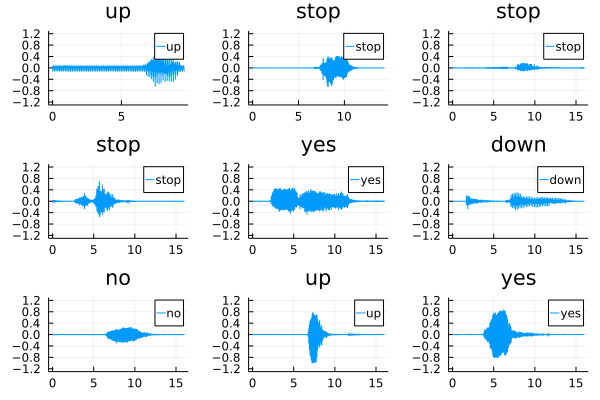

In [32]:
using Plots

rows = 3
cols = 3

n = rows*cols

figs = [
    plot(
        (1:length(waveform_ds[i][1]))./1e3, waveform_ds[i][1],
        title = waveform_ds[i][2],
        yticks = -1.2:0.4:1.2,
        label = waveform_ds[i][2],
        ylim = (-1.3,1.3),
        xticks = 0:5:15,
    )
    for i=1:n
]

plot(figs...,layout=(rows,cols))

In [33]:
# Compute spectragrams (with stft)
# Compared to tf function the spectrogram from DSP.stft is transposed

using DSP

function get_spectrogram(waveform)
    input_len = 16000
    waveform = length(waveform) >= input_len ? 
                    waveform[1:input_len]    :
                    [convert.(Float32,waveform);zeros(Float32,input_len - length(waveform))]
    spectrogram = DSP.stft(
        waveform,
        255,
        255-128, 
        window=hanning,
        fs=fs,
    ) |> x->abs.(x)
    spectrogram
end

get_spectrogram(waveform_ds[1][1])

129×124 Matrix{Float32}:
 0.151658     0.111054     0.0505158    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.99168      2.97518      2.88819         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 5.58722      5.62292      5.49623         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.65652      3.72994      3.63189         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.81054      1.86692      1.88054         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.840381     0.878547     0.911536     …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0654138    0.0793213    0.037288        0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.218005     0.23755      0.283673        0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.422487     0.456245     0.461687        0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.346657     0.365106     0.332001        0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                                      ⋱                 ⋮              
 0.000134475  5.37284f-5   0.0060629    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.87118f-5   0.000265674  0.00475797      0.0  0.0  0

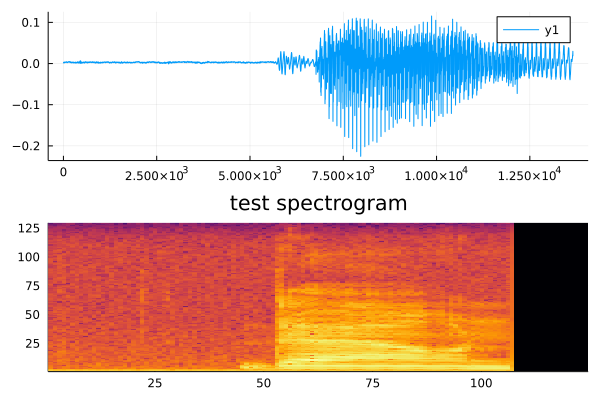

In [34]:
# Function to plot spectrograms
# I was too lazy to fix the xticks of the spectrogram

function plot_spectrogram(spectrogram, title)
    tmp = similar(spectrogram)
    if (length(size(spectrogram))>2)
        @assert length(size(spectrogram)) == 3
        tmp = spectrogram[:,:,1]
    else
        tmp = spectrogram
    end
    log_spec = log.(tmp .+ eps(Float32))
    heatmap(log_spec, legend=false, title=title)
end


tst_waveform = decode_audio("../dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav")
tst_spectrogram = get_spectrogram(tst_waveform)

p1 = plot(tst_waveform)
p2 = plot_spectrogram(tst_spectrogram, "test spectrogram")

plot(p1,p2, layout=(2,1))

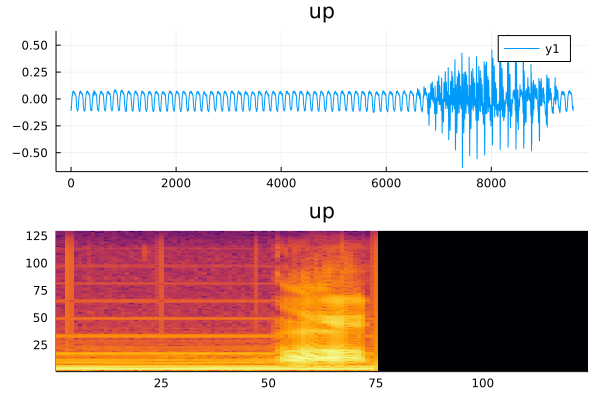

size(x) = (129, 124, 1)
commands = ["down", "go", "left", "no", "right", "stop", "up", "yes"]


Bool[0, 0, 0, 0, 0, 0, 1, 0]


In [35]:
using Flux

# Function to get spectrogram label pairs
# Deviation from TF - I store labels in onehot format
function get_spectrogram_and_label_id((waveform, label))
    spectrogram = convert.(Float32,get_spectrogram(waveform))
    reshape(spectrogram,size(spectrogram)...,1), Flux.onehot(label,commands)
end

# Check the function
x,y = get_spectrogram_and_label_id((waveform_ds[1][1], waveform_ds[1][2]))
p1 = plot(waveform_ds[1][1][:,:,1,1],title="$(waveform_ds[1][2])")
@show size(x)
p2 = plot_spectrogram(x, "$(waveform_ds[1][2])")
@show commands
plot(p1, p2, layout=(2,1)) |> display
println(y)

In [36]:
spectrogram_ds = get_spectrogram_and_label_id.(waveform_ds)

800-element Vector{Tuple{Array{Float32, 3}, Flux.OneHotArray{UInt32, 8, 0, 1, UInt32}}}:
 ([0.1516575 0.11105414 … 0.0 0.0; 2.991682 2.9751775 … 0.0 0.0; … ; 9.313734f-5 5.8084413f-5 … 0.0 0.0; 9.466708f-5 0.000104404986 … 0.0 0.0;;;], [0, 0, 0, 0, 0, 0, 1, 0])
 ([0.0035720973 0.0013479091 … 0.0 0.0; 0.017473467 0.010879901 … 0.0 0.0; … ; 3.7628517f-5 7.846311f-5 … 0.0 0.0; 0.00015300256 0.00010024535 … 0.0 0.0;;;], [0, 0, 0, 0, 0, 1, 0, 0])
 ([0.037238244 0.01797866 … 0.2614622 0.22995739; 0.04223383 0.040702216 … 0.7834785 0.69056726; … ; 6.438281f-5 9.308669f-5 … 7.987235f-6 7.3297604f-5; 0.000111522 0.00015433978 … 3.656608f-5 0.00012827085;;;], [0, 0, 0, 0, 0, 1, 0, 0])
 ([0.0076322015 0.012127457 … 0.09406115 0.034876693; 0.039648782 0.038138922 … 0.0879615 0.05548789; … ; 0.009670256 0.003979604 … 3.978562f-5 0.0005151685; 0.0059816414 0.0010649754 … 0.00044834864 0.00080316735;;;], [0, 0, 0, 0, 0, 1, 0, 0])
 ([0.01736481 0.005518132 … 0.00017099475 0.028878028; 0.07316476 0.046

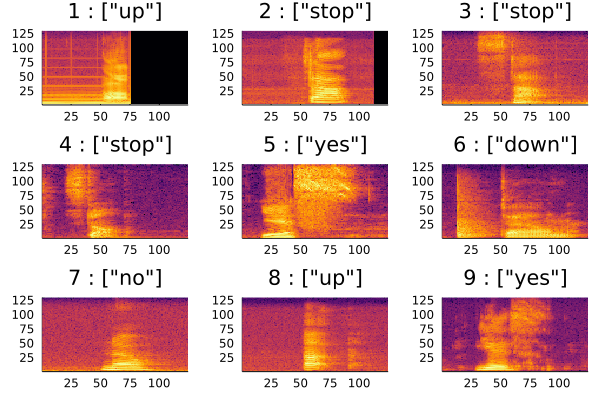

In [37]:
rows = 3
cols = 3
n = rows*cols

figs = [
    plot_spectrogram(spectrogram_ds[i][1][:,:,1,1],"$i : $(commands[spectrogram_ds[i][2]])")
    for i=1:n
]

plot(figs...,layout=(rows,cols))

In [38]:
for i=1:9
    wavplay(waveform_ds[i][1],fs)
end

In [39]:
# Function to prepare all data needed for training, validation and testing
function preprocess_dataset(files)
    files_ds = [get_waveform_and_label(f) for f=files]
    get_spectrogram_and_label_id.(files_ds)
end

preprocess_dataset (generic function with 1 method)

In [40]:
# Prepare Data
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

800-element Vector{Tuple{Array{Float32, 3}, Flux.OneHotArray{UInt32, 8, 0, 1, UInt32}}}:
 ([0.0005024891 0.0006034966 … 0.0001702989 9.095159f-5; 0.00045413736 0.0003848244 … 0.00034471325 6.576265f-5; … ; 5.3215263f-5 2.7363438f-5 … 0.00013073973 0.00012028397; 8.19394f-6 6.241515f-5 … 0.00017585926 0.00015080126;;;], [0, 1, 0, 0, 0, 0, 0, 0])
 ([0.059801534 0.027081659 … 0.049932774 0.024817962; 0.1473253 0.222664 … 0.11300869 0.1048254; … ; 0.0004639682 0.00038115715 … 0.00085427566 0.0010159892; 0.00020500757 0.0001819692 … 0.00074516353 0.0012548243;;;], [0, 0, 0, 0, 0, 0, 1, 0])
 ([6.105446f-5 0.00021381846 … 0.0047778925 0.002157069; 0.008000833 0.0132531645 … 0.02966198 0.010196195; … ; 6.6751614f-5 0.00012992139 … 0.00011065299 1.6166814f-5; 5.6994682f-5 0.00017084292 … 0.00013352843 9.766338f-6;;;], [0, 0, 0, 0, 0, 1, 0, 0])
 ([0.00036616807 0.0008496817 … 0.0026646028 0.00044207656; 0.0010959147 0.00069049664 … 0.008932095 0.0017684906; … ; 0.00018940202 0.00013814638 … 7.42

In [41]:
train_ds_x = Flux.batch([d[1] for d=train_ds[1:3200]]) # I have to convert train_ds in two parts otherwise I get stackoverflow
train_ds_x = cat(train_ds_x,Flux.batch([d[1] for d=train_ds[3201:end]]),dims=4) # Flux.batch([d[1] for d=train_ds[1:3200]])
train_ds_y = Flux.batch([d[2] for d=train_ds])
val_ds_x = Flux.batch([d[1] for d=val_ds])
val_ds_y = Flux.batch([d[2] for d=val_ds])

8×800 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [42]:
# Finally use the DataLoader

trainingData = Flux.DataLoader((train_ds_x, train_ds_y), batchsize=64,shuffle=true)
valData = Flux.DataLoader((val_ds_x, val_ds_y), batchsize=64)

MLUtils.DataLoader{Tuple{Array{Float32, 4}, Flux.OneHotArray{UInt32, 8, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG, Val{nothing}}(([0.1516575 0.11105414 … 0.0 0.0; 2.991682 2.9751775 … 0.0 0.0; … ; 9.313734f-5 5.8084413f-5 … 0.0 0.0; 9.466708f-5 0.000104404986 … 0.0 0.0;;;; 0.0035720973 0.0013479091 … 0.0 0.0; 0.017473467 0.010879901 … 0.0 0.0; … ; 3.7628517f-5 7.846311f-5 … 0.0 0.0; 0.00015300256 0.00010024535 … 0.0 0.0;;;; 0.037238244 0.01797866 … 0.2614622 0.22995739; 0.04223383 0.040702216 … 0.7834785 0.69056726; … ; 6.438281f-5 9.308669f-5 … 7.987235f-6 7.3297604f-5; 0.000111522 0.00015433978 … 3.656608f-5 0.00012827085;;;; … ;;;; 9.222644f-5 0.0005435095 … 9.933517f-5 0.001792075; 0.0037619052 0.003733069 … 0.003607051 0.0100775715; … ; 5.855616f-5 9.809525f-5 … 6.483255f-5 3.4063145f-5; 5.706243f-5 0.00012969394 … 3.4408604f-5 1.888176f-5;;;; 0.14435363 0.12044642 … 0.0 0.0; 0.0996398 0.096330054 … 0.0 0.0; … ; 9.933624f-5 0.00016190062 … 0.0 0.0; 0.00010243058 0.00012919307 … 0

In [51]:
# ds_mean = sum(train_ds_x) / prod(size(train_ds_x))
# ds_sqrt_var = sqrt(sum((train_ds_x .- ds_mean).^2) / prod(size(train_ds_x)))
using Statistics
# Compute mean 
ds_mean =  mean(train_ds_x)
ds_sqrt_var = sqrt(var(train_ds_x))

0.75872f0

In [52]:
# Model Definition

model = Chain(
    Upsample(:bilinear,size=(32,32)),
    x->(x .- ds_mean) ./ ds_sqrt_var,
    Conv((3,3),1=>32, Flux.relu),
    Conv((3,3),32=>64, Flux.relu),
    MaxPool((2,2)),
    Dropout(0.25),
    Flux.flatten,
    Dense(12544=>128,relu),
    Dropout(0.5),
    Dense(128=>length(commands)),
)
# Checking 
@show size(train_ds[1][1])
model(reshape(train_ds[1][1],size(train_ds[1][1])...,1))

size((train_ds[1])[1]) = (129, 124, 1)


8×1 Matrix{Float32}:
  0.24645373
 -0.14024219
  0.17892854
 -0.02053341
 -0.107743815
 -0.16422638
  0.045982424
 -0.35781178

In [53]:
# Loss Function
function loss(x,y)
    ŷ = model(x)
    Flux.Losses.logitcrossentropy(ŷ,y)
end

# Check Accuracy
function getAccuracy(m,d)
    acc = 0
    for (x,y)=d
        ŷ = model(x)
        acc += sum(Flux.onecold(ŷ) .== Flux.onecold(y)) / size(x)[end]
    end
    acc/length(d)
end

# Total Loss
function loss_tot(d)
    l = 0
    for (x,y) = d
        l+= loss(x,y)
    end
    return l/length(d)
end

loss_tot (generic function with 1 method)

In [54]:
# Goes very slow :''(
@show loss_tot(valData) 
@show getAccuracy(model,valData)

loss_tot(valData) = 2.0957797f0


getAccuracy(model, valData) = 0.1346153846153846


0.1346153846153846

In [55]:
opt = Flux.Optimise.ADAM()
ps = Flux.params(model)
testmode!(model,false)

evalcb() = println("Loss: $(loss_tot(valData))")

Flux.@epochs 10 Flux.train!(
    loss,
    ps,
    trainingData,
    opt,
    cb=Flux.throttle(evalcb,10),
)

@show getAccuracy(model,valData)

┌ Info: Epoch 1
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 2.1068435


Loss: 1.7329025


Loss: 1.4326812

┌ Info: Epoch 2
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 1.4321126


Loss: 1.2782166


Loss: 1.0822337


┌ Info: Epoch 3
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 1.1077342


Loss: 1.0230806


Loss: 1.0153533


┌ Info: Epoch 4
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 0.96668255


Loss: 0.93705463


Loss: 0.9150133


┌ Info: Epoch 5
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 0.9472238


Loss: 0.8793801


Loss: 0.8900366


Loss: 0.9603555


┌ Info: Epoch 6
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 0.83323264


Loss: 0.8338546


Loss: 0.9300441


┌ Info: Epoch 7
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 0.8564288


Loss: 0.82752216


Loss: 0.8042333


┌ Info: Epoch 8
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 0.96532875


Loss: 0.86991256


Loss: 0.8398285


┌ Info: Epoch 9
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 0.79230815


Loss: 0.8831498


Loss: 0.8346605


┌ Info: Epoch 10
└ @ Main C:\Users\detter55\.julia\packages\Flux\js6mP\src\optimise\train.jl:154


Loss: 0.83169323


Loss: 0.9029931

Loss: 0.8404448


getAccuracy(model, valData) = 0.7644230769230769


0.7644230769230769

In [ ]:
using Flux, Plots
x = reshape(convert.(Float32,1:124*129), 124,129,1,1)
y = upsample_bilinear(x,size=(32,32))

fig1 = heatmap(x[:,:,1,1])
fig2 = heatmap(y[:,:,1,1])
plot(fig1,fig2, layout=(1,2))